# Phục hồi ảnh bị tác động bởi degradation function

Do tác động của Degration function nên chất lượng ảnh bị suy giảm. <br>
Phục hồi ảnh quan tâm đến việc cải thiện chất lượng ảnh với các phương pháp phù hợp, sử dụng những kiến thức phù hợp về những yếu tố làm thay đổi chất lượng ảnh, cụ thể là *blur* và *nhiễu (noise)*
Trong notebook này, chúng tôi thực hiện qua 2 quá trình <br>
<ol style="padding-bottom: 10px;">
<li> Biến đổi ảnh gốc với degradation functions
<li> Phục hồi ảnh nhiễu thông qua các bộ lọc phù hợp
</ol>
Để thuận lợi, ảnh đã được chuyển về ảnh xám.

## Inverse Filter

### 1. Mô phỏng biến đổi ảnh gốc
Xem xét một ảnh, nhóm biến đổi một ảnh thông qua một hàm degration $h(\mathbf{x})$ (đóng vai trò là kernel)



In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from numpy.fft import fft, ifft, fftshift
from scipy.fftpack import fftn, ifftn, fftshift

In [3]:
def gaussian_kernel(k = 5, sigma = 1.0):
    arx = np.arange((-k // 2) + 1.0, (k // 2) + 1.0)
    x, y = np.meshgrid(arx, arx)
    filt = np.exp(-(1/2) * (np.square(x) + np.square(y)) / np.square(sigma))
    return filt / np.sum(filt)

In [4]:
kernel = gaussian_kernel(5)
print(kernel)

[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]]


(-0.5, 2117.5, 1190.5, -0.5)

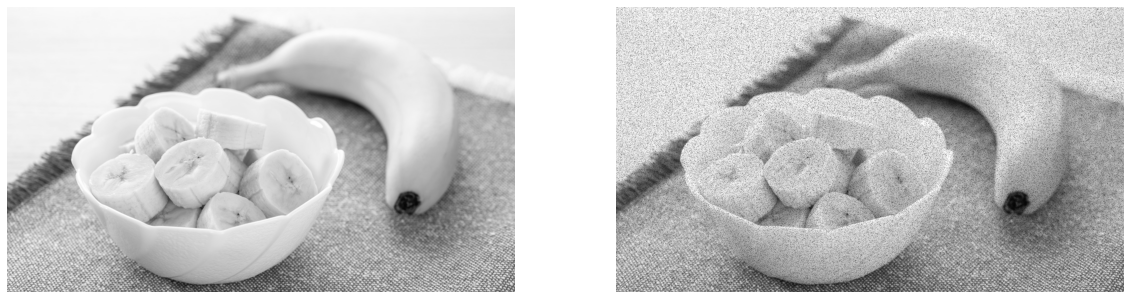

In [5]:
from add_noise import SaltAndPeperNoise
import cv2
from config import Flag
import matplotlib.pyplot as plt

prefix = Flag.image_origin
file_name = prefix / 'banana.jpg'
im = cv2.imread(str(file_name),0)
# plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
saltAndPeperNoise = SaltAndPeperNoise(str(file_name), s_vs_p=1, amount=0.1)
sapn = saltAndPeperNoise.noise()
image_noise = sapn

plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(122)
plt.imshow(cv2.cvtColor(sapn, cv2.COLOR_BGR2RGB))
plt.axis('off')

Text(0.5, 1.0, 'degraded/blurred image')

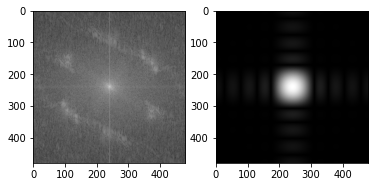

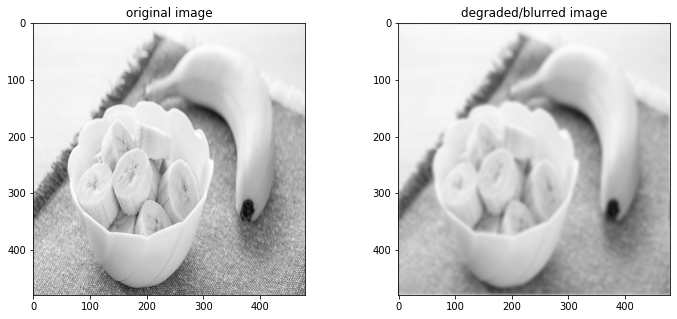

In [6]:
f = cv2.imread(str(file_name),0)
f = cv2.resize(f, (480, 480))
h = gaussian_kernel(k=9, sigma=3)

# computing the number of padding on one side
a = int(f.shape[0]//2 - h.shape[0]//2)
h_pad = np.pad(h, (a,a-1), 'constant', constant_values=(0))

# computing the Fourier transforms
F = fftn(f)
H = fftn(h_pad)

plt.subplot(121)
plt.imshow(fftshift(np.log(np.abs(F)+1)), cmap="gray")
plt.subplot(122)
plt.imshow(fftshift(np.log(np.abs(H)+1)), cmap="gray")

# convolution
G = np.multiply(F,H)

# Inverse Transform
# - we have to perform FFT shift before reconstructing the image in the space domain
g = fftshift(ifftn(G).real)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")

### 2. Sử dụng inverse filter với blured image (chưa có noise)

Text(0.5, 1.0, 'restored image')

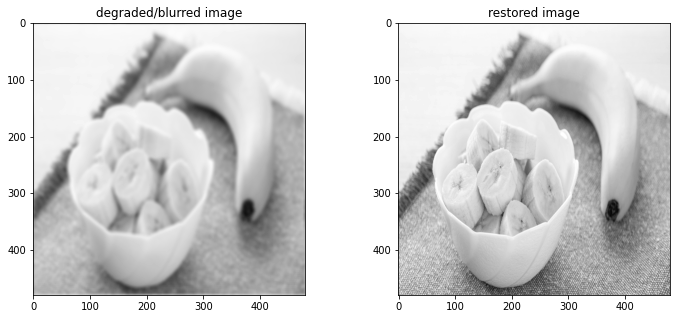

In [7]:
#F_hat = G/H
F_hat = np.divide(G,H)

f_hat = ifftn(F_hat).real

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.subplot(122)
plt.imshow(f_hat, cmap="gray", vmin=0, vmax=255); plt.title("restored image")


from https://dsp.stackexchange.com/questions/29545/why-does-this-reconstruction-produce-a-phase-shift-from-the-original-signal
The shift is due to using an FFT with a different length than the length of the data, and likely using a non-symmetric arrangement of zero-padding to increase that original length to the zero-padded length.

Non-symmetric zero-padding rotates the phase results of an FFT, spiraling across result bins.

## Wiener Filter

(-0.5, 479.5, 479.5, -0.5)

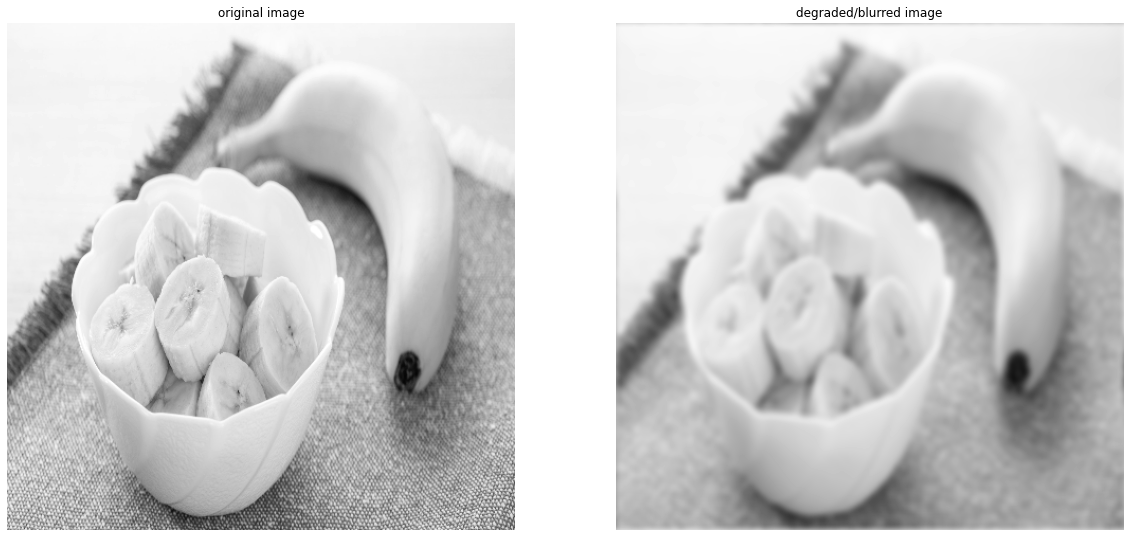

In [8]:
f = cv2.imread(str(file_name),0)
f = cv2.resize(f, (480, 480))
h = gaussian_kernel(k=11, sigma=3)

# computing the number of padding on one side
a = int(f.shape[0]//2 - h.shape[0]//2)
h_pad = np.pad(h, (a,a-1), 'constant', constant_values=(0))

# computing the Fourier transforms
F = fftn(f)
H = fftn(h_pad)

# convolution
G = np.multiply(F,H)

# Inverse Transform
# - we have to perform FFT shift before reconstructing the image in the space domain
g = fftshift(ifftn(G).real)
plt.figure(figsize=(20,12))
plt.subplot(121)
plt.axis('off')
plt.imshow(f, cmap="gray", vmin=0, vmax=255); plt.title("original image")
plt.subplot(122)
plt.imshow(g, cmap="gray", vmin=0, vmax=255); plt.title("degraded/blurred image")
plt.axis('off')


(480, 480)


(-0.5, 479.5, 479.5, -0.5)

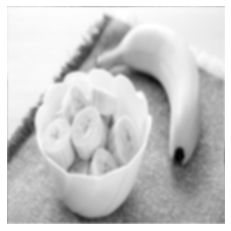

In [9]:
im_noise = np.copy(g)

print(im_noise.shape)
plt.imshow(im_noise, cmap='gray')
plt.axis("off")

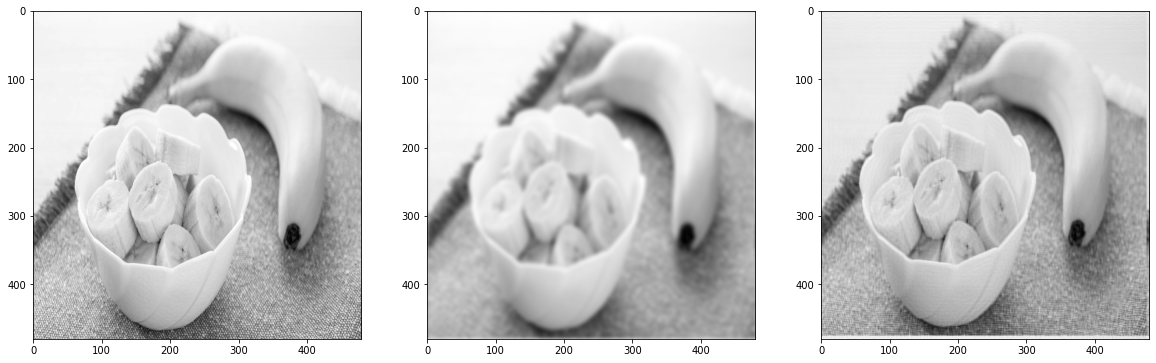

In [28]:
K = 0.000025
G_wiener = fftn(im_noise)
h_wiener = gaussian_kernel(k=11,sigma = 3)

h_wiener_pad = np.zeros(im_noise.shape)
h_wiener_pad[:h_wiener.shape[0], :h_wiener.shape[1]] = np.copy(h_wiener)

H_wiener = fftn(h_wiener_pad)
#3. Find the inverse filter term
weiner_term = (abs(H_wiener)**2 + K)/(abs(H_wiener)**2)

H_weiner = H_wiener*weiner_term
F_wiener = G_wiener/H_weiner
f_hat = ifftn(F_wiener).real
restored = abs(f_hat)
plt.figure(figsize=(20,12))
plt.subplot(131)
plt.imshow(f, cmap='gray')
plt.subplot(132)
plt.imshow(im_noise, cmap='gray')
plt.subplot(133)
plt.imshow(f_hat, cmap='gray')       
